In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cuda device


In [ ]:
# @title Download and preprocess the CIFAR-100 dataset
import torch
import torchvision
import torchvision.transforms as transforms


train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.1),

    transforms.ToTensor(),
    transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
    )


])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
    )
])



# Load CIFAR-100 dataset
class_trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
class_testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)


class_trainloader = torch.utils.data.DataLoader(class_trainset, batch_size=128, shuffle=True)
class_testloader = torch.utils.data.DataLoader(class_testset, batch_size=128, shuffle=False)


100%|██████████| 169001437/169001437 [00:02<00:00, 66197485.53it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


(32, 32, 3)


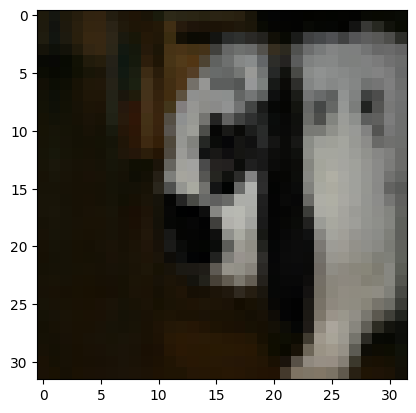

In [ ]:
import numpy as np,matplotlib.pyplot as plt
plt.imshow(class_trainset.data[33])
print(class_trainset.data[33].shape)

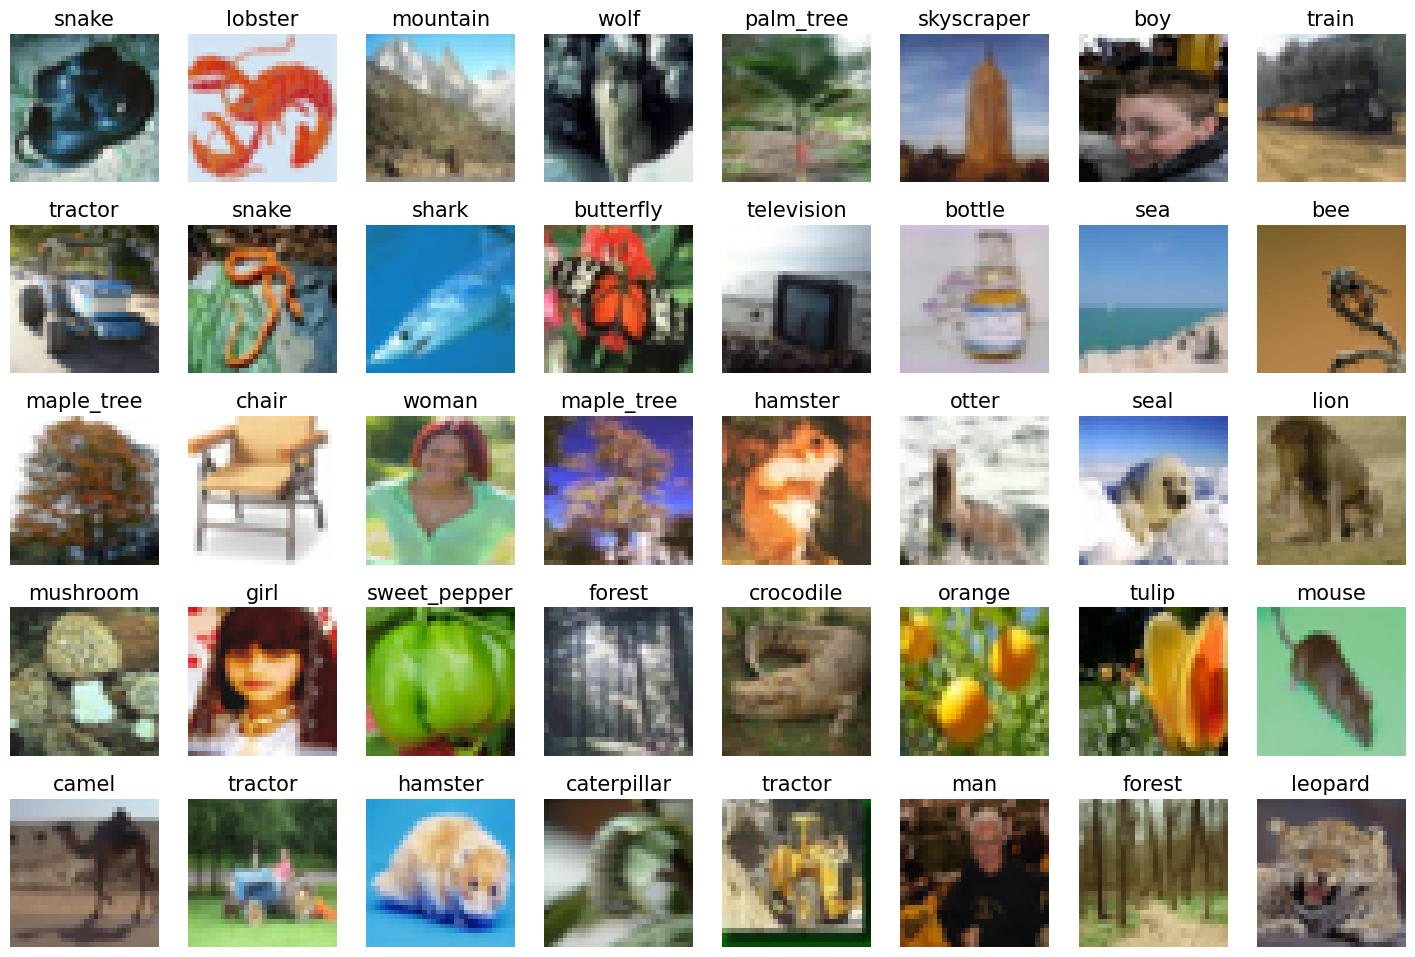

In [ ]:
# @title Visualize few images from the training samples
classes = class_trainset.classes
pos = 0
fig = plt.figure(figsize=(18,12))
for image in range(40,80):
  fig.add_subplot(5, 8, pos+1)
  plt.imshow(class_trainset.data[image])
  plt.title(classes[class_trainset.targets[image]], fontsize=15)
  plt.axis(False)
  pos += 1

In [ ]:
categories = [['beaver', 'dolphin', 'otter', 'seal', 'whale'],
              ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
              ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
              ['bottle', 'bowl', 'can', 'cup', 'plate'],
              ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
              ['clock', 'keyboard', 'lamp', 'telephone', 'television'],
              ['bed', 'chair', 'couch', 'table', 'wardrobe'],
              ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
              ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
              ['bridge', 'castle', 'house', 'road', 'skyscraper'],
              ['cloud', 'forest', 'mountain', 'plain', 'sea'],
              ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
              ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
              ['crab', 'lobster', 'snail', 'spider', 'worm'],
              ['baby', 'boy', 'girl', 'man', 'woman'],
              ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
              ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
              ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
              ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
              ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']]

class_to_category = dict()

for category_idx, category in enumerate(categories):
  for cls in category:
    cls_idx = class_trainset.class_to_idx[cls]
    class_to_category[cls_idx] = category_idx

def get_category(t):
  return class_to_category[t]

In [ ]:
from numpy.ma.core import reshape
import torch
import torch.nn as nn
import torch.nn.functional as F



class ClassModel(nn.Module):
    def __init__(self):
        super(ClassModel, self).__init__()


        self.conv_layer = torchvision.models.efficientnet_v2_s(pretrained=True).features
        self.conv_layer[:int(len(self.conv_layer)*0.5)].requires_grad_(False)

        # self.conv_layer = nn.Sequential(
        #   nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=(1,1), padding='same'),
        #   nn.BatchNorm2d(16),
        #   nn.ReLU(),
        #   nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,  stride=2),
        #   nn.BatchNorm2d(32),
        #   nn.ReLU(),
        # )
#         a=[32,128,64]
        # a=[32,128,64,128,256]
        # for i in range(1,len(a)):
        #   self.conv_layer.append(nn.Conv2d(in_channels=a[i-1], out_channels=a[i], kernel_size=3, stride=(1,1), padding='same')),
        #   self.conv_layer.append(nn.BatchNorm2d(a[i])),
        #   self.conv_layer.append(nn.ReLU()),
        #   self.conv_layer.append(nn.Conv2d(in_channels=a[i], out_channels=a[i], kernel_size=3, stride=(1,1), padding='same')),
        #   self.conv_layer.append(nn.BatchNorm2d(a[i])),
        #   self.conv_layer.append(nn.ReLU()),



        self.linear_layer_general = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=1280, out_features=20),
        )

        self.linear_layer_special =  nn.Linear(in_features=1300, out_features=100)


    def forward(self, x):
      out = self.conv_layer(x)
      out = F.adaptive_avg_pool2d(out, (1, 1))
      features = torch.flatten(out, 1)
      out_general = self.linear_layer_general(features)
      out_special = self.linear_layer_special(torch.cat((features, out_general), dim=1))
      return out_general, out_special


class_model = ClassModel().to(device)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 155MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title  Train the class-level classification model
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import os
from torch.optim.lr_scheduler import MultiStepLR


class_criterion = nn.CrossEntropyLoss()
class_optimizer = optim.Adam(
    [{
        "params": class_model.conv_layer.parameters(),
        "lr": 5e-4,
    },
    {
        "params": class_model.linear_layer_general.parameters(),
        "lr": 1e-3,
    },
     {
        "params": class_model.linear_layer_special.parameters(),
        "lr": 1e-3,
    },
     ],
    weight_decay=1e-4)
scheduler = MultiStepLR(class_optimizer, milestones=[1, 5, 8], gamma=0.1, verbose=True)


# class_criterion = nn.CrossEntropyLoss()
# class_optimizer = optim.Adam(class_model.parameters(), lr=5e-4, weight_decay=1e-5)

# checkpoints
# state_dict = torch.load('/content/drive/MyDrive/'+f'checkpoint_{69}.pt')
# class_model.load_state_dict(state_dict['model'])
# class_optimizer.load_state_dict(state_dict['optimizer'])


def train(class_trainloader, class_model, loss_fn, class_optimizer):
    size = len(class_trainloader.dataset)
    tot_iter = 0
    running_loss = 0.0
    corrects = 0

    for i, data in enumerate(class_trainloader):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # Forward
        outputs_general, outputs_special = class_model(inputs)

        labels_general = torch.tensor([get_category(label.item()) for label in labels]).cuda()

        loss = loss_fn(outputs_general, labels_general) + loss_fn(outputs_special, labels)

        class_optimizer.zero_grad()

        # Backward
        loss.backward()
        class_optimizer.step()

        running_loss += loss.item()
        corrects += (outputs_special.argmax(1) == labels).type(torch.float).sum().item()

        if i % 50 == 0:
            loss ,current = loss.item(), (i+1)*len(inputs)
            print(f"Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        del inputs
        del labels
        torch.cuda.empty_cache()
    corrects/=size
    print(f"Train Accuracy: {(100*corrects):>0.1f}")





def test(class_testloader, class_model, loss_fn):
    class_model.eval()
    class_correct = 0
    total = 0
    size = len(class_testloader.dataset)
    num_batches = len(class_testloader)

    with torch.no_grad():
        for data in class_testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()

            # Forward
            outputs_general, outputs_special = class_model(images)

            labels_general = torch.tensor([get_category(label.item()) for label in labels]).cuda()

            total += loss_fn(outputs_general, labels_general).item() + loss_fn(outputs_special, labels).item()

            class_correct += (outputs_special.argmax(1) == labels).type(torch.float).sum().item()

    total /= num_batches
    class_correct /= size

    print(f"Test Accuracy: {(100*class_correct):>0.1f}%, Avg loss: {total:>8f} \n")


epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------------")
    train(class_trainloader, class_model, class_criterion, class_optimizer)
    # checkpoint
    checkpoint = {'epoch' : epochs , 'model' : class_model.state_dict() , 'optimizer' : class_optimizer.state_dict() }
    path =  '/content/drive/MyDrive/'+f'checkpoint_{t}.pt'
    torch.save(checkpoint,path)

    test(class_testloader, class_model, class_criterion)
    scheduler.step()

print(path)

print("Done :)")

Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 1 to 1.0000e-03.
Adjusting learning rate of group 2 to 1.0000e-03.
Epoch 1
---------------------------------
Train loss: 6.222303  [  128/50000]
Train loss: 2.095576  [ 6528/50000]
Train loss: 1.885489  [12928/50000]
Train loss: 1.742587  [19328/50000]
Train loss: 1.383424  [25728/50000]
Train loss: 1.397788  [32128/50000]
Train loss: 1.498364  [38528/50000]
Train loss: 1.774511  [44928/50000]
Train Accuracy: 64.8


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test Accuracy: 74.4%, Avg loss: 1.357804 

Adjusting learning rate of group 0 to 5.0000e-05.
Adjusting learning rate of group 1 to 1.0000e-04.
Adjusting learning rate of group 2 to 1.0000e-04.
Epoch 2
---------------------------------
Train loss: 1.054087  [  128/50000]
Train loss: 1.037386  [ 6528/50000]
Train loss: 0.698252  [12928/50000]
Train loss: 0.538072  [19328/50000]
Train loss: 0.924037  [25728/50000]
Train loss: 0.775938  [32128/50000]
Train loss: 0.800080  [38528/50000]
Train loss: 0.897608  [44928/50000]
Train Accuracy: 83.3
Test Accuracy: 80.1%, Avg loss: 1.006852 

Adjusting learning rate of group 0 to 5.0000e-05.
Adjusting learning rate of group 1 to 1.0000e-04.
Adjusting learning rate of group 2 to 1.0000e-04.
Epoch 3
---------------------------------
Train loss: 0.776574  [  128/50000]
Train loss: 0.474634  [ 6528/50000]
Train loss: 0.551638  [12928/50000]
Train loss: 0.533617  [19328/50000]
Train loss: 0.586470  [25728/50000]
Train loss: 0.724011  [32128/50000]
Train